In [1]:
import gym 
import numpy as np
from custom_envs.gridworlds import WindyGridworldEnv, SimpleGridworldEnv

from function_approximators.function_approximators import NeuralNetwork, LinearModel, DecisionTree, RandomForest, ExtraTrees, GradientBoostingTrees, SupportVectorRegressor

from utils.train_utils import train
from utils.plot_utils import plot_returns

from agents.agents import DQNAgent, LinearAgent, NonParametricAgent


In [2]:
function_approximators = [NeuralNetwork, LinearModel, DecisionTree, RandomForest, ExtraTrees, GradientBoostingTrees, SupportVectorRegressor]
agents = [DQNAgent, LinearAgent, *[NonParametricAgent]*5]

RENDER = False
env = gym.make("CartPole-v1")
# env = gym.make("Acrobot-v1")
# env = gym.make("MountainCar-v0")
# env = WindyGridworldEnv()
# env = gym.make("LunarLander-v2")
# env = SimpleGridworldEnv()

In [3]:
# DQN Config
CONFIG_DQN = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 10,
    "learning_rate": 0.00075,
    "hidden_size": (32,32),
    "target_update_freq": 200,
    "batch_size": 32,
    "gamma": 0.99,
    "buffer_capacity": int(1e7),
    "plot_loss": False,
    "epsilon": 1,
    "max_deduct": 0.97,
    "decay": 0.2,
    "lr_step_size": 1000,
    "lr_gamma": 0.95,
    "max_steps": 200,
    "non_param": False,
}

# Linear Config
CONFIG_LINEAR = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 10,
    "learning_rate": 0.02,
    "target_update_freq": 50,
    "batch_size": 32,
    "gamma": 0.99,
    "buffer_capacity": int(1e7),
    "plot_loss": False,
    "epsilon": 1,
    "max_steps": 200,
    "poly_degree": 2,
    "max_deduct": 0.97,
    "decay": 0.5,
    "lr_step_size": 1000,
    "lr_gamma": 0.99,
    "non_param": False,
}

# Decision Tree Config
CONFIG_DT = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 10,
    "model_save_freq": 1000,
    "model_save_capacity": 20,
    "update_freq": 1,
    "batch_size": 512,
    "gamma": 0.99,
    "buffer_capacity": int(1e6),
    "epsilon": 1,
    "max_deduct": 0.95,
    "decay": 0.4,
    "max_steps": 200,
    "non_param": True,
    "model_params": {"criterion":"mse","max_depth": 10, "min_samples_split": 20, "min_samples_leaf": 5},
}

# Random Forest Config
CONFIG_RF = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 10,
    "model_save_freq": 1000,
    "model_save_capacity": 20,
    "batch_size": 512,
    "gamma": 0.99,
    "buffer_capacity": int(1e5),
    "epsilon": 1,
    "max_deduct": 0.95,
    "decay": 0.3,
    "max_steps": 200,
    "non_param": True,
    "model_params": {"n_estimators": 10,"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 10},
}

# Extra Trees Config
CONFIG_ET = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 10,
    "model_save_freq": 1000,
    "model_save_capacity": 20,
    "batch_size": 512,
    "gamma": 0.99,
    "buffer_capacity": int(1e5),
    "epsilon": 1,
    "max_deduct": 0.95,
    "decay": 0.3,
    "max_steps": 200,
    "non_param": True,
    "model_params": {"n_estimators": 10,"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 10},
}

# Gradient Boosting Trees Config
CONFIG_RF = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 10,
    "model_save_freq": 1000,
    "model_save_capacity": 20,
    "batch_size": 512,
    "gamma": 0.99,
    "buffer_capacity": int(1e5),
    "epsilon": 1,
    "max_deduct": 0.95,
    "decay": 0.3,
    "max_steps": 200,
    "non_param": True,
    "model_params": {"loss":"ls","learning_rate":0.1, "n_estimators": 10,"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 10},
}

# Support Vector Regressor Config
CONFIG_SVR = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 3,
    "model_save_freq": 1000,
    "model_save_capacity": 10,
    "batch_size": 512,
    "gamma": 0.99,
    "buffer_capacity": int(1e5),
    "epsilon": 1,
    "max_deduct": 0.95,
    "decay": 0.3,
    "max_steps": 200,
    "non_param": True,
    "model_params": {"kernel":"rbf", "degree": 2, "C": 1},
}


In [6]:
# Random Forest Config
CONFIG_RF = {
    "episode_length": 200,
    "max_timesteps": 20000,
    "max_time": 30 * 60,
    "eval_freq": 1000, 
    "eval_episodes": 5,
    "model_save_freq": 1000,
    "model_save_capacity": 20,
    "update_freq": 20,
    "batch_size": 512,
    "gamma": 0.99,
    "buffer_capacity": int(1e6),
    "epsilon": 1,
    "max_deduct": 0.95,
    "decay": 0.4,
    "max_steps": 200,
    "non_param": True,
    "export_tree": True,
    "model_params": {"n_estimators":10,"max_depth": 10, "min_samples_split": 20, "min_samples_leaf": 5},
}

returns = []
n_seeds=5

j=3
for i in range(n_seeds):
    print(f"\n Run: {i+1} \n")
    r, _ = train(env, 
            CONFIG_RF, 
            fa=function_approximators[j], 
            agent = agents[j], 
            render=RENDER)
    env.close()
    returns.append(r)

  3%|▎         | 574/20000 [00:00<00:04, 4701.20it/s]
 Run: 1 

  5%|▌         | 1070/20000 [00:02<00:58, 321.66it/s] Evaluation at timestep 1018 returned a mean returns of 194.2
Epsilon = 0.8833875
 10%|█         | 2092/20000 [00:07<00:41, 430.30it/s]Evaluation at timestep 2092 returned a mean returns of 145.0
Epsilon = 0.762975
 15%|█▌        | 3064/20000 [00:14<06:30, 43.37it/s] Evaluation at timestep 3021 returned a mean returns of 173.6
Epsilon = 0.6525375
 21%|██        | 4184/20000 [00:26<01:22, 192.74it/s]Evaluation at timestep 4184 returned a mean returns of 176.0
Epsilon = 0.5269
 25%|██▌       | 5020/20000 [00:38<01:58, 126.74it/s]Evaluation at timestep 5020 returned a mean returns of 159.79999999999998
Epsilon = 0.421925
 31%|███       | 6155/20000 [00:56<02:11, 104.95it/s]Evaluation at timestep 6155 returned a mean returns of 159.0
Epsilon = 0.28904375000000004
 35%|███▌      | 7013/20000 [01:16<03:13, 67.09it/s]Evaluation at timestep 7013 returned a mean returns of 162.0


KeyboardInterrupt: 

In [75]:
mean = [np.mean(returns, axis=0)]
std = [np.std(returns, axis=0)]
print(mean[-1])
print(std[-1])


[ 25.13 106.79 131.38 149.11 158.69 160.78 169.92 170.3  169.96 174.53
 171.9  178.26 171.91 176.73 175.58 177.96 164.27 167.02 164.01 166.01]
[ 8.44121437 73.22125989 63.7154267  45.71184639 48.82793156 36.41251982
 32.85114305 34.02934028 30.37769577 25.70646028 25.52093258 21.24938587
 28.15103728 23.50608645 26.71672884 23.02612429 45.11035469 36.96557317
 43.44160333 41.45779661]


In [76]:
with open(f'cartpole_Random Forest.csv', 'ab') as f:
    np.savetxt(f, mean, delimiter=',')
    np.savetxt(f, std, delimiter=',')
        

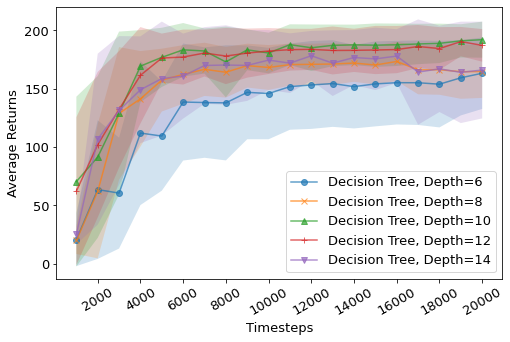

In [1]:
from utils.plot_utils import plot_returns
import numpy as np

legends = ["Decision Tree, Depth=6", "Decision Tree, Depth=8", "Decision Tree, Depth=10", "Decision Tree, Depth=12", "Decision Tree, Depth=14"]
markers = ["o","x","^","+","v"]
means = []
stds = []
for i in range(len(legends)):
    a = np.genfromtxt(f'cartpole_{legends[i]}.csv', delimiter=',')
    means.append(a[0])
    stds.append(a[1])

plot_returns(save_name="cartpole_dt_depths", values=means, stds=stds, xlabel="Timesteps", ylabel="Average Returns", legend_names=legends, eval_freq=1000, markers=markers)

